In [1]:
from glob import glob
import pandas as pd
from scipy.stats import spearmanr
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

def p_adjust(pvalues, method='fdr_bh'):
    res = multipletests(pvalues, method=method)
    return np.array(res[1], dtype=float)

# Correlating Kraken abundances with continuous vaccine titers

##### Michael Shaffer
##### 7/21/2022
##### Merck ESC, Sys bio group

To find if any bacterial taxa are correlated with vaccine response we will pick time points (2, 4, 6, 8 and 12 months) and correlate the bacterial abundances at those timepoints with continuous vaccine response at one year.

## Read in data

In [2]:
meta = pd.read_csv('../../data/metadata/stool/stool_metadata.csv', index_col='SampleID')
meta = pd.concat([meta,
                  pd.read_csv('../../data/metadata/stool/stool_abx_usage.csv', index_col='SampleID'),
                  pd.read_csv('../../data/metadata/stool/stool_titers_yr1.csv', index_col='SampleID')],
                 axis=1)
meta['VR_group'] = meta['VR_group'].fillna('Not Measured')
meta = meta.sort_values(['BabyN', 'age_at_collection'])
meta = meta.loc[~pd.isna(meta['median_mmNorm'])]
meta.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,median_mmNorm_PCV,median_mmNorm_DTAPHib,protectNorm_Dip,protectNorm_TET,protectNorm_PRP (Hib),protectNorm_PT,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2
SampleID,,,,,,,,,,,,,,,,,,,,,
106_V2,Primary in Tube,69,NaN,NaN,"Box 8, F3",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
106_V6,Primary in Tube,121,NaN,NaN,"Box 10, C1",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
106_V7,Primary in Tube,158,NaN,NaN,"Box 11, C3",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
106_S_1,Primary in Tube,162,NaN,NaN,"Box 11, D1",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR
106_A1,Primary in Tube,188,NaN,NaN,"Box 12, B3",Stool,Human Infant,MetaG,106,NaN,...,0.061955,0.052874,2.1,3.0,2.6,0.3125,0.3125,1.375,1.140388,NVR


In [3]:
kraken_genus_abunds = pd.read_csv('../../data/stool/kraken_taxa_level_abunds/kraken_genus_abunds.tsv', sep='\t', index_col=0)
kraken_genus_abunds = kraken_genus_abunds[meta.query("`gt_2.5` == True").index]
print(kraken_genus_abunds.shape)
display(kraken_genus_abunds.head())

(971, 529)


,106_V2,106_V6,106_V7,106_S_1,106_A1,107_V2,107_V3,107_V6,107_S1,107_V7,...,264_S2F,264_V9,264_V10,264_V11,264_V12,265_V2,265_V5,265_V6,265_V8,265_S1
d__Bacteria|g__Thermobaculum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacterium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,10.0,4.0,0.0,0.0,0.0,0.0,0.0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Candidatus_Koribacter,0.0,0.0,17.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,2.0,5.0,0.0,2.0,0.0,4.0,0.0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,1.0,13.0,6.0,0.0,1.0,0.0,8.0,0.0
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,14.0,3.0,0.0,2.0,0.0,3.0,0.0


In [4]:
kraken_family_abunds = pd.read_csv('../../data/stool/kraken_taxa_level_abunds/kraken_family_abunds.tsv', sep='\t', index_col=0)
kraken_family_abunds = kraken_family_abunds[meta.query("`gt_2.5` == True").index]
print(kraken_family_abunds.shape)
display(kraken_family_abunds.head())

(320, 529)


,106_V2,106_V6,106_V7,106_S_1,106_A1,107_V2,107_V3,107_V6,107_S1,107_V7,...,264_S2F,264_V9,264_V10,264_V11,264_V12,265_V2,265_V5,265_V6,265_V8,265_S1
d__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae,0.0,0.0,17.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,3.0,39.0,20.0,0.0,5.0,0.0,15.0,0.0
d__Bacteria|p__Acidobacteria|c__Solibacteres|o__Solibacterales|f__Solibacteraceae,0.0,0.0,14.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d__Bacteria|p__Actinobacteria|c__Acidimicrobiia|o__Acidimicrobiales|f__Acidimicrobiaceae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Acidothermales|f__Acidothermaceae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae,0.0,163.0,6.0,5.0,283.0,0.0,9.0,87.0,82.0,18.0,...,1817.0,32.0,33.0,33.0,48.0,98.0,14.0,16.0,64.0,174.0


In [5]:
in_both = set(meta.index) & set(kraken_genus_abunds.columns)
meta_matched = meta.loc[in_both]
print(meta_matched.shape)

(529, 86)


/var/folders/6t/1w2t3qmd1rx81mfw9sq_tfpr0000gn/T/ipykernel_12559/1022001642.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  meta_matched = meta.loc[in_both]


In [6]:
meta_v5 = meta_matched.query("VisitCode == 'V5'")
meta_v6 = meta_matched.query("VisitCode == 'V6'")
meta_v7 = meta_matched.query("VisitCode == 'V7'")
meta_v9 = meta_matched.query("VisitCode == 'V9'")

meta_PCV = meta_matched.loc[~pd.isna(meta_matched['median_mmNorm_PCV'])]
meta_PCV_v5 = meta_PCV.query("VisitCode == 'V5'")
meta_PCV_v6 = meta_PCV.query("VisitCode == 'V6'")
meta_PCV_v7 = meta_PCV.query("VisitCode == 'V7'")
meta_PCV_v9 = meta_PCV.query("VisitCode == 'V9'")

## Genus level correlations with median of all titers

In [7]:
kraken_genus_abunds_v5 = kraken_genus_abunds[meta_v5.index]
kraken_genus_abunds_v5 = kraken_genus_abunds_v5.loc[(kraken_genus_abunds_v5 > 0).sum(axis=1) > kraken_genus_abunds_v5.shape[1]*.2]
print(len(kraken_genus_abunds_v5))
v5_correlations = kraken_genus_abunds_v5.transpose().apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations.columns = ['rho', 'p_value']
v5_correlations['p_adj'] = p_adjust(v5_correlations['p_value'])
v5_correlations = v5_correlations.sort_values('p_value')
v5_correlations.head()

331


,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobacteraceae|g__Desulfatibacillum,0.411292,0.006144,0.776318
d__Bacteria|p__Firmicutes|g__Ndongobacter,0.405958,0.006913,0.776318
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas,0.387339,0.010283,0.776318
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Propionimicrobium,0.376331,0.012874,0.776318
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Odoribacter,0.371907,0.014061,0.776318


In [8]:
kraken_genus_abunds_v6 = kraken_genus_abunds[meta_v6.index]
kraken_genus_abunds_v6 = kraken_genus_abunds_v6.loc[(kraken_genus_abunds_v6 > 0).sum(axis=1) > kraken_genus_abunds_v6.shape[1]*.2]
v6_correlations = kraken_genus_abunds_v6.transpose().apply(spearmanr, b=meta_v6['median_mmNorm']).transpose()
v6_correlations.columns = ['rho', 'p_value']
v6_correlations['p_adj'] = p_adjust(v6_correlations['p_value'])
v6_correlations = v6_correlations.sort_values('p_value')
v6_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Oligoflexia|o__Bacteriovoracales|f__Halobacteriovoraceae|g__Halobacteriovorax,0.409617,0.005202,0.997781
d__Bacteria|p__Cyanobacteria|o__Chroococcales|f__Chroococcaceae|g__Geminocystis,0.335120,0.024430,0.997781
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Propionibacteriales|f__Propionibacteriaceae|g__Propionimicrobium,0.326688,0.028502,0.997781
d__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Melissococcus,0.317101,0.033801,0.997781
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella,0.316709,0.034034,0.997781


In [9]:
kraken_genus_abunds_v7 = kraken_genus_abunds[meta_v7.index]
kraken_genus_abunds_v7 = kraken_genus_abunds_v7.loc[(kraken_genus_abunds_v7 > 0).sum(axis=1) > kraken_genus_abunds_v7.shape[1]*.2]
v7_correlations = kraken_genus_abunds_v7.transpose().apply(spearmanr, b=meta_v7['median_mmNorm']).transpose()
v7_correlations.columns = ['rho', 'p_value']
v7_correlations['p_adj'] = p_adjust(v7_correlations['p_value'])
v7_correlations = v7_correlations.sort_values('p_value')
v7_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Proteus,0.383268,0.006008,0.995738
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Gallibacterium,-0.360547,0.010108,0.995738
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Cronobacter,-0.346676,0.013648,0.995738
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Legionellales|f__Legionellaceae|g__Legionella,0.326401,0.020701,0.995738
d__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Hymenobacteraceae|g__Pontibacter,0.318392,0.024232,0.995738


In [10]:
kraken_genus_abunds_v9 = kraken_genus_abunds[meta_v9.index]
kraken_genus_abunds_v9 = kraken_genus_abunds_v9.loc[(kraken_genus_abunds_v9 > 0).sum(axis=1) > kraken_genus_abunds_v9.shape[1]*.2]
v9_correlations = kraken_genus_abunds_v9.transpose().apply(spearmanr, b=meta_v9['median_mmNorm']).transpose()
v9_correlations.columns = ['rho', 'p_value']
v9_correlations['p_adj'] = p_adjust(v9_correlations['p_value'])
v9_correlations = v9_correlations.sort_values('p_value')
v9_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Olsenella,0.490337,0.000979,0.270850
d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae|g__Altererythrobacter,0.489523,0.001001,0.270850
d__Bacteria|p__Actinobacteria|c__Rubrobacteria|o__Rubrobacterales|f__Rubrobacteraceae|g__Rubrobacter,0.448357,0.002903,0.523470
d__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Finegoldia,0.430471,0.004432,0.599479
d__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Jeotgalibacillus,0.404899,0.007818,0.832174


Nothing is significant at the genus level.

## Family level correlations with median of all titers

In [11]:
kraken_family_abunds_v5 = kraken_family_abunds[meta_v5.index]
kraken_family_abunds_v5 = kraken_family_abunds_v5.loc[(kraken_family_abunds_v5 > 0).sum(axis=1) > kraken_family_abunds_v5.shape[1]*.2]
v5_correlations = kraken_family_abunds_v5.transpose().apply(spearmanr, b=meta_v5['median_mmNorm']).transpose()
v5_correlations.columns = ['rho', 'p_value']
v5_correlations['p_adj'] = p_adjust(v5_correlations['p_value'])
v5_correlations = v5_correlations.sort_values('p_value')
v5_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermacoccaceae,-0.476670,0.001231,0.204417
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobacteraceae,0.420848,0.004951,0.410965
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Thiotrichales|f__Piscirickettsiaceae,0.373152,0.013718,0.583544
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae,0.371907,0.014061,0.583544
d__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Hymenobacteraceae,0.332068,0.029593,0.738694


In [12]:
kraken_family_abunds_v6 = kraken_family_abunds[meta_v6.index]
kraken_family_abunds_v6 = kraken_family_abunds_v6.loc[(kraken_family_abunds_v6 > 0).sum(axis=1) > kraken_family_abunds_v6.shape[1]*.2]
v6_correlations = kraken_family_abunds_v6.transpose().apply(spearmanr, b=meta_v6['median_mmNorm']).transpose()
v6_correlations.columns = ['rho', 'p_value']
v6_correlations['p_adj'] = p_adjust(v6_correlations['p_value'])
v6_correlations = v6_correlations.sort_values('p_value')
v6_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Oligoflexia|o__Bacteriovoracales|f__Halobacteriovoraceae,0.409617,0.005202,0.807816
d__Bacteria|p__Cyanobacteria|o__Chroococcales|f__Chroococcaceae,0.383083,0.009393,0.807816
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae,0.316709,0.034034,0.995092
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae,0.286955,0.055980,0.995092
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Myxococcales|f__Myxococcaceae,0.282137,0.060419,0.995092


In [13]:
kraken_family_abunds_v7 = kraken_family_abunds[meta_v7.index]
kraken_family_abunds_v7 = kraken_family_abunds_v7.loc[(kraken_family_abunds_v7 > 0).sum(axis=1) > kraken_family_abunds_v7.shape[1]*.2]
v7_correlations = kraken_family_abunds_v7.transpose().apply(spearmanr, b=meta_v7['median_mmNorm']).transpose()
v7_correlations.columns = ['rho', 'p_value']
v7_correlations['p_adj'] = p_adjust(v7_correlations['p_value'])
v7_correlations = v7_correlations.sort_values('p_value')
v7_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae,0.324532,0.021484,0.99836
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis,0.312812,0.026981,0.99836
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Marinilabiliales|f__Marinifilaceae,0.287802,0.042693,0.99836
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Legionellales|f__Legionellaceae,0.267673,0.060202,0.99836
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae,0.251141,0.078537,0.99836


In [14]:
kraken_family_abunds_v9 = kraken_family_abunds[meta_v9.index]
kraken_family_abunds_v9 = kraken_family_abunds_v9.loc[(kraken_family_abunds_v9 > 0).sum(axis=1) > kraken_family_abunds_v9.shape[1]*.2]
v9_correlations = kraken_family_abunds_v9.transpose().apply(spearmanr, b=meta_v9['median_mmNorm']).transpose()
v9_correlations.columns = ['rho', 'p_value']
v9_correlations['p_adj'] = p_adjust(v9_correlations['p_value'])
v9_correlations = v9_correlations.sort_values('p_value')
v9_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae,0.546170,0.000183,0.031558
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae,0.533177,0.000277,0.031558
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Nitrosomonadales|f__Methylophilaceae,0.520369,0.000412,0.031558
d__Bacteria|p__Actinobacteria|c__Rubrobacteria|o__Rubrobacterales|f__Rubrobacteraceae,0.448357,0.002903,0.166910
d__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae,0.425753,0.004938,0.227135


There are three significant results but they are all ocean bacteria. These are likely artifacts of an old and incomplete Kraken database.

In [15]:
sig_families_v9 = pd.concat((kraken_family_abunds_v9.loc[v9_correlations.query("p_adj < .05").index].transpose(), meta_v9['median_mmNorm'], meta_v9['median_mmNorm_DTAPHib'], meta_v9['median_mmNorm_PCV']), axis=1)

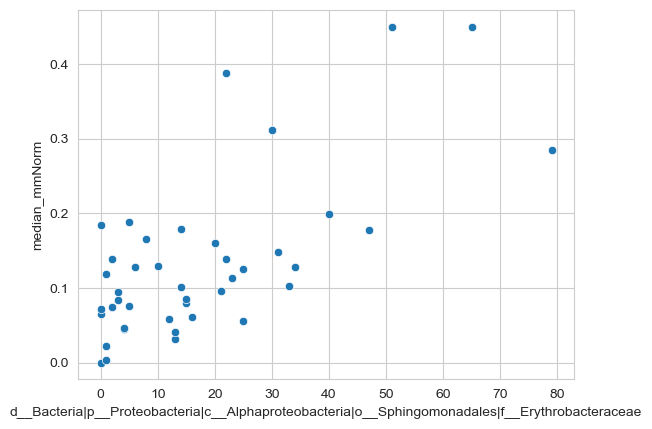

In [16]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae', y='median_mmNorm', data=sig_families_v9)

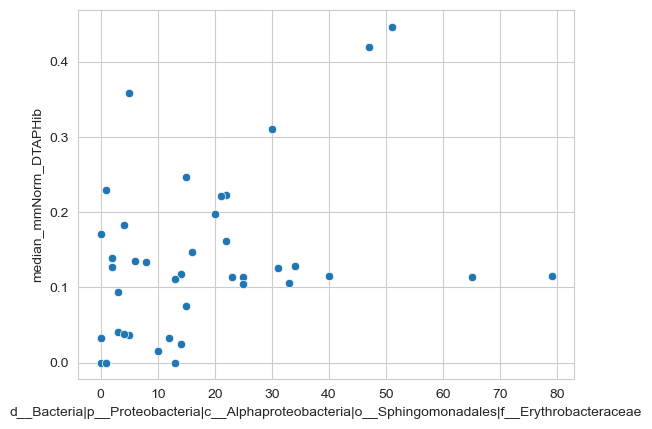

In [17]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae', y='median_mmNorm_DTAPHib', data=sig_families_v9)

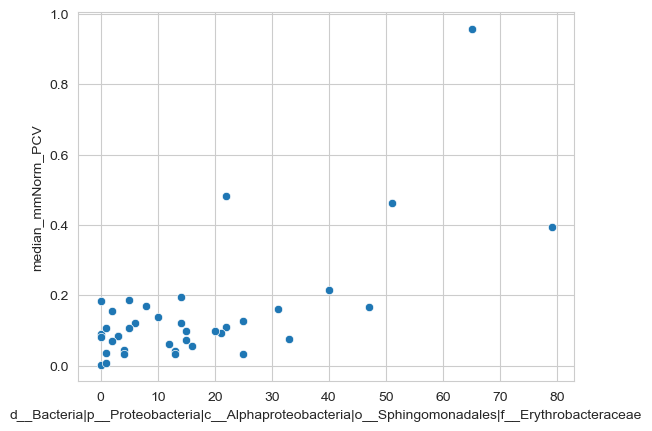

In [18]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae', y='median_mmNorm_PCV', data=sig_families_v9)

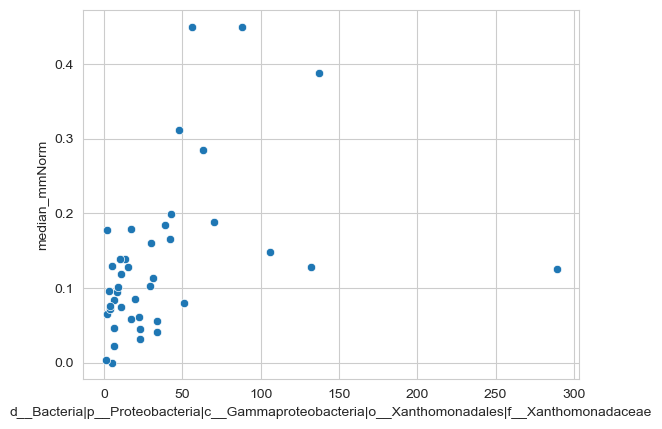

In [19]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae', y='median_mmNorm', data=sig_families_v9)

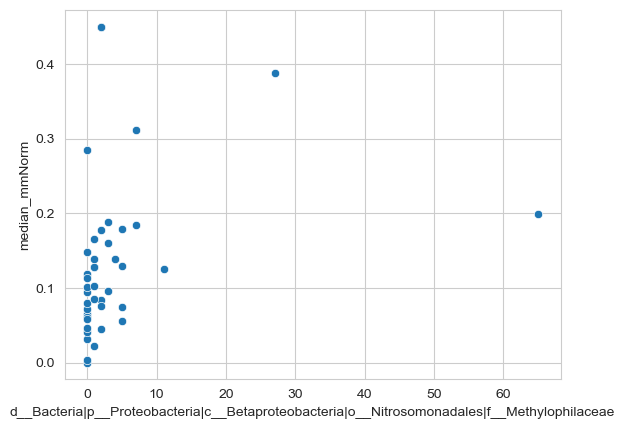

In [20]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Nitrosomonadales|f__Methylophilaceae', y='median_mmNorm', data=sig_families_v9)

### Dig into genuses within Erythrobacteraceae

In [21]:
erythrobacteraceae_genuses = [i for i in kraken_genus_abunds_v9.index
                              if 'd__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae' in i]
erythrobacteraceae_genuses_v9 = pd.concat((kraken_genus_abunds_v9.loc[erythrobacteraceae_genuses].transpose(), meta_v9['median_mmNorm']), axis=1)

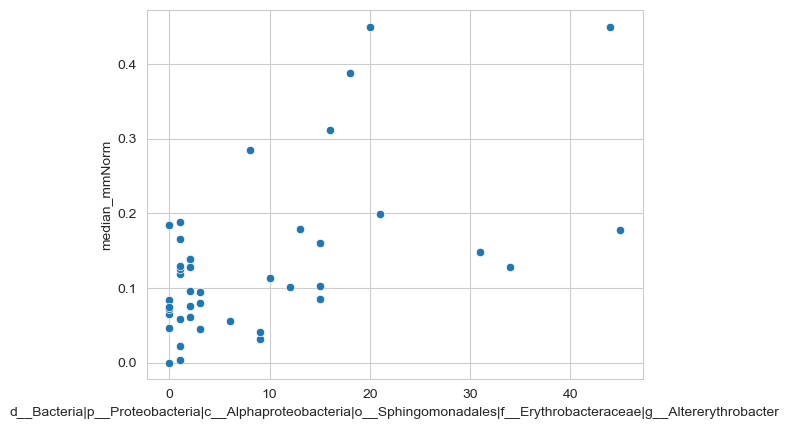

In [22]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae|g__Altererythrobacter', y='median_mmNorm', data=erythrobacteraceae_genuses_v9)

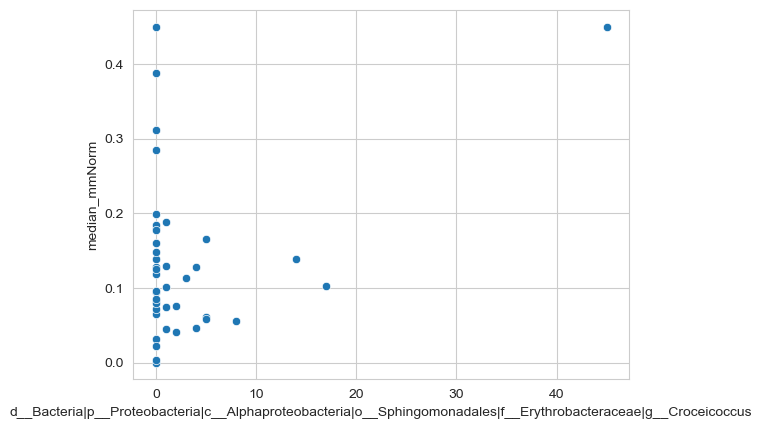

In [23]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae|g__Croceicoccus', y='median_mmNorm', data=erythrobacteraceae_genuses_v9)

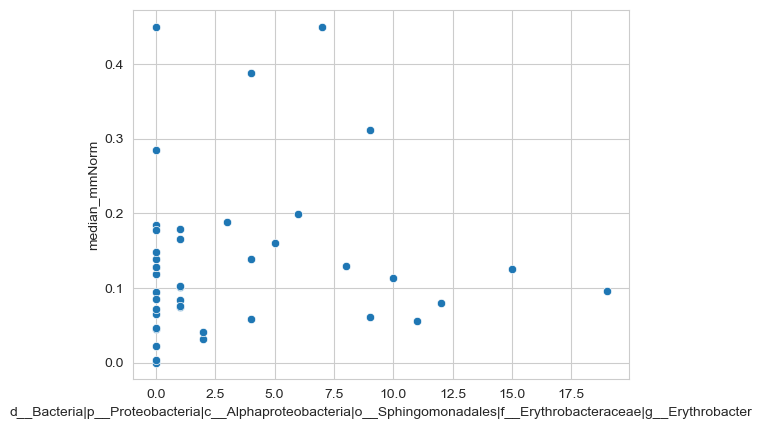

In [24]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae|g__Erythrobacter', y='median_mmNorm', data=erythrobacteraceae_genuses_v9)

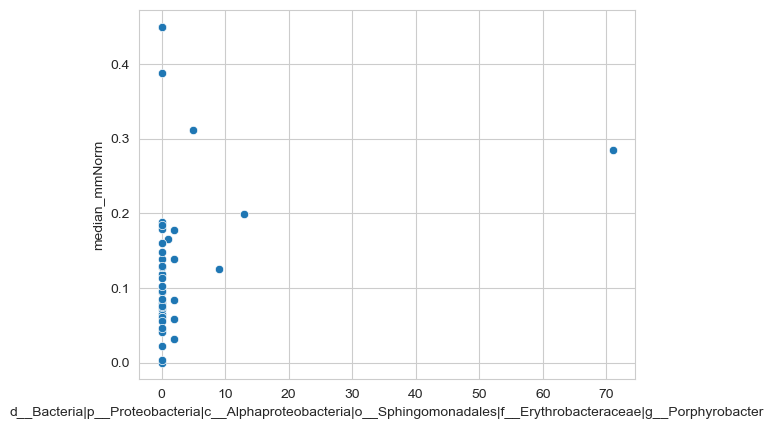

In [25]:
_ = sns.scatterplot(x='d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae|g__Porphyrobacter', y='median_mmNorm', data=erythrobacteraceae_genuses_v9)

None of the individual genuses that are within the most significant family have compelling results.

## Correlate genuses with separate median titers

In [26]:
v5_DTAPHib_correlations = kraken_genus_abunds_v5.transpose().apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations.columns = ['rho', 'p_value']
v5_DTAPHib_correlations['p_adj'] = p_adjust(v5_DTAPHib_correlations['p_value'])
v5_DTAPHib_correlations = v5_DTAPHib_correlations.sort_values('p_value')
v5_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfuromonadales|f__Desulfuromonadaceae|g__Desulfuromonas,0.447871,0.002599,0.433603
d__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Eggerthellales|f__Eggerthellaceae|g__Slackia,0.429681,0.004033,0.433603
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Odoribacter,0.427017,0.004293,0.433603
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobacteraceae|g__Desulfatibacillum,0.404371,0.007157,0.433603
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Vitreoscilla,0.401139,0.007678,0.433603


In [27]:
kraken_genus_abunds_PCV_v5 = kraken_genus_abunds[meta_PCV_v5.index]
kraken_genus_abunds_PCV_v5 = kraken_genus_abunds_PCV_v5.loc[(kraken_genus_abunds_PCV_v5 > 0).sum(axis=1) > kraken_genus_abunds_PCV_v5.shape[1]*.2]
v5_PCV_correlations = kraken_genus_abunds_PCV_v5.transpose().apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations.columns = ['rho', 'p_value']
v5_PCV_correlations['p_adj'] = p_adjust(v5_PCV_correlations['p_value'])
v5_PCV_correlations = v5_PCV_correlations.sort_values('p_value')
v5_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Micrococcaceae|g__Micrococcus,-0.492113,0.001258,0.391275
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Cellvibrionales|f__Cellvibrionaceae|g__Cellvibrio,-0.360835,0.022171,0.975943
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Heliobacteriaceae|g__Heliobacterium,-0.357215,0.023647,0.975943
d__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema,0.351903,0.025959,0.975943
d__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Faecalibaculum,-0.345544,0.028971,0.975943


In [28]:
v6_DTAPHib_correlations = kraken_genus_abunds_v6.transpose().apply(spearmanr, b=meta_v6['median_mmNorm_DTAPHib']).transpose()
v6_DTAPHib_correlations.columns = ['rho', 'p_value']
v6_DTAPHib_correlations['p_adj'] = p_adjust(v6_DTAPHib_correlations['p_value'])
v6_DTAPHib_correlations = v6_DTAPHib_correlations.sort_values('p_value')
v6_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas,0.483099,0.000776,0.270651
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Cupriavidus,-0.420240,0.004052,0.546198
d__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Melissococcus,0.414017,0.004695,0.546198
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae|g__Odoribacter,0.348202,0.019080,0.968895
d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Bradyrhizobiaceae|g__Rhodopseudomonas,0.338676,0.022865,0.968895


In [29]:
kraken_genus_abunds_PCV_v6 = kraken_genus_abunds[meta_PCV_v6.index]
kraken_genus_abunds_PCV_v6 = kraken_genus_abunds_PCV_v6.loc[(kraken_genus_abunds_PCV_v6 > 0).sum(axis=1) > kraken_genus_abunds_PCV_v6.shape[1]*.2]
v6_PCV_correlations = kraken_genus_abunds_PCV_v6.transpose().apply(spearmanr, b=meta_PCV_v6['median_mmNorm_PCV']).transpose()
v6_PCV_correlations.columns = ['rho', 'p_value']
v6_PCV_correlations['p_adj'] = p_adjust(v6_PCV_correlations['p_value'])
v6_PCV_correlations = v6_PCV_correlations.sort_values('p_value')
v6_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Oligoflexia|o__Bacteriovoracales|f__Halobacteriovoraceae|g__Halobacteriovorax,0.415055,0.005648,0.998997
d__Bacteria|p__Cyanobacteria|o__Chroococcales|f__Chroococcaceae|g__Geminocystis,0.350181,0.021332,0.998997
d__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Elizabethkingia,0.347964,0.022226,0.998997
d__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Melissococcus,0.329809,0.030788,0.998997
d__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Planococcaceae|g__Jeotgalibacillus,0.300350,0.050355,0.998997


In [30]:
v7_DTAPHib_correlations = kraken_genus_abunds_v7.transpose().apply(spearmanr, b=meta_v7['median_mmNorm_DTAPHib']).transpose()
v7_DTAPHib_correlations.columns = ['rho', 'p_value']
v7_DTAPHib_correlations['p_adj'] = p_adjust(v7_DTAPHib_correlations['p_value'])
v7_DTAPHib_correlations = v7_DTAPHib_correlations.sort_values('p_value')
v7_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|g__Candidatus_Azobacteroides,0.340544,0.015524,0.98824
d__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Sporomusaceae|g__Pelosinus,-0.330158,0.019201,0.98824
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Gordoniaceae|g__Gordonia,-0.323988,0.021716,0.98824
d__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Virgibacillus,-0.321188,0.022946,0.98824
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia,-0.319824,0.023566,0.98824


In [31]:
meta_PCV_v7 = meta_PCV.query("VisitCode == 'V7'")
kraken_genus_abunds_PCV_v7 = kraken_genus_abunds[meta_PCV_v7.index]
kraken_genus_abunds_PCV_v7 = kraken_genus_abunds_PCV_v7.loc[(kraken_genus_abunds_PCV_v7 > 0).sum(axis=1) > kraken_genus_abunds_PCV_v7.shape[1]*.2]
v7_PCV_correlations = kraken_genus_abunds_PCV_v7.transpose().apply(spearmanr, b=meta_PCV_v7['median_mmNorm_PCV']).transpose()
v7_PCV_correlations.columns = ['rho', 'p_value']
v7_PCV_correlations['p_adj'] = p_adjust(v7_PCV_correlations['p_value'])
v7_PCV_correlations = v7_PCV_correlations.sort_values('p_value')
v7_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Rahnella,-0.400221,0.005312,0.990765
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Morganellaceae|g__Proteus,0.352449,0.015110,0.990765
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Mogibacterium,0.327107,0.024814,0.990765
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Syntrophobotulus,0.321208,0.027701,0.990765
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Gallibacterium,-0.312558,0.032436,0.990765


In [32]:
v9_DTAPHib_correlations = kraken_genus_abunds_v9.transpose().apply(spearmanr, b=meta_v9['median_mmNorm_DTAPHib']).transpose()
v9_DTAPHib_correlations.columns = ['rho', 'p_value']
v9_DTAPHib_correlations['p_adj'] = p_adjust(v9_DTAPHib_correlations['p_value'])
v9_DTAPHib_correlations = v9_DTAPHib_correlations.sort_values('p_value')
v9_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|g__Mitsuaria,0.403966,0.007975,0.899798
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae|g__Serratia,0.402992,0.008142,0.899798
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Psychrobacter,0.383877,0.012083,0.899798
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales|f__Rhodocyclaceae|g__Azospira,0.383440,0.012189,0.899798
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae|g__Cnuibacter,-0.362197,0.018417,0.899798


In [33]:
meta_PCV_v9 = meta_PCV.query("VisitCode == 'V9'")
kraken_genus_abunds_PCV_v9 = kraken_genus_abunds[meta_PCV_v9.index]
kraken_genus_abunds_PCV_v9 = kraken_genus_abunds_PCV_v9.loc[(kraken_genus_abunds_PCV_v9 > 0).sum(axis=1) > kraken_genus_abunds_PCV_v9.shape[1]*.2]
v9_PCV_correlations = kraken_genus_abunds_PCV_v9.transpose().apply(spearmanr, b=meta_PCV_v9['median_mmNorm_PCV']).transpose()
v9_PCV_correlations.columns = ['rho', 'p_value']
v9_PCV_correlations['p_adj'] = p_adjust(v9_PCV_correlations['p_value'])
v9_PCV_correlations = v9_PCV_correlations.sort_values('p_value')
v9_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae|g__Olsenella,0.474720,0.002262,0.850475
d__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Mycoplasma,0.452213,0.003850,0.850475
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia,0.397368,0.012248,0.850475
d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae|g__Altererythrobacter,0.396013,0.012574,0.850475
d__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Faecalitalea,0.392935,0.013343,0.850475


## Correlate families with separate median titers

In [34]:
v5_DTAPHib_correlations = kraken_family_abunds_v5.transpose().apply(spearmanr, b=meta_v5['median_mmNorm_DTAPHib']).transpose()
v5_DTAPHib_correlations.columns = ['rho', 'p_value']
v5_DTAPHib_correlations['p_adj'] = p_adjust(v5_DTAPHib_correlations['p_value'])
v5_DTAPHib_correlations = v5_DTAPHib_correlations.sort_values('p_value')
v5_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobacteraceae,0.435404,0.003521,0.189563
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae,0.427017,0.004293,0.189563
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermacoccaceae,-0.426291,0.004366,0.189563
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae,0.424349,0.004568,0.189563
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Geodermatophilales|f__Geodermatophilaceae,0.371850,0.014077,0.399871


In [35]:
kraken_family_abunds_PCV_v5 = kraken_family_abunds[meta_PCV_v5.index]
kraken_family_abunds_PCV_v5 = kraken_family_abunds_PCV_v5.loc[(kraken_family_abunds_PCV_v5 > 0).sum(axis=1) > kraken_family_abunds_PCV_v5.shape[1]*.2]
v5_PCV_correlations = kraken_family_abunds_PCV_v5.transpose().apply(spearmanr, b=meta_PCV_v5['median_mmNorm_PCV']).transpose()
v5_PCV_correlations.columns = ['rho', 'p_value']
v5_PCV_correlations['p_adj'] = p_adjust(v5_PCV_correlations['p_value'])
v5_PCV_correlations = v5_PCV_correlations.sort_values('p_value')
v5_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfobacterales|f__Desulfobacteraceae,0.462848,0.002636,0.340386
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Dermacoccaceae,-0.442706,0.004228,0.340386
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Heliobacteriaceae,-0.357215,0.023647,0.903793
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Thiotrichales|f__Piscirickettsiaceae,0.337771,0.033040,0.903793
d__Bacteria|p__Proteobacteria|c__Oligoflexia|o__Bacteriovoracales|f__Halobacteriovoraceae,0.319039,0.044795,0.903793


In [36]:
v6_DTAPHib_correlations = kraken_family_abunds_v6.transpose().apply(spearmanr, b=meta_v6['median_mmNorm_DTAPHib']).transpose()
v6_DTAPHib_correlations.columns = ['rho', 'p_value']
v6_DTAPHib_correlations['p_adj'] = p_adjust(v6_DTAPHib_correlations['p_value'])
v6_DTAPHib_correlations = v6_DTAPHib_correlations.sort_values('p_value')
v6_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae,0.371120,0.012079,0.820452
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae,0.359315,0.015346,0.820452
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae,0.355038,0.016703,0.820452
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Odoribacteraceae,0.348202,0.019080,0.820452
d__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Myxococcales|f__Myxococcaceae,0.318225,0.033141,0.897028


In [37]:
kraken_family_abunds_PCV_v6 = kraken_family_abunds[meta_PCV_v6.index]
kraken_family_abunds_PCV_v6 = kraken_family_abunds_PCV_v6.loc[(kraken_family_abunds_PCV_v6 > 0).sum(axis=1) > kraken_family_abunds_PCV_v6.shape[1]*.2]
v6_PCV_correlations = kraken_family_abunds_PCV_v6.transpose().apply(spearmanr, b=meta_PCV_v6['median_mmNorm_PCV']).transpose()
v6_PCV_correlations.columns = ['rho', 'p_value']
v6_PCV_correlations['p_adj'] = p_adjust(v6_PCV_correlations['p_value'])
v6_PCV_correlations = v6_PCV_correlations.sort_values('p_value')
v6_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Oligoflexia|o__Bacteriovoracales|f__Halobacteriovoraceae,0.415055,0.005648,0.786961
d__Bacteria|p__Cyanobacteria|o__Chroococcales|f__Chroococcaceae,0.395067,0.008744,0.786961
d__Bacteria|p__Aquificae|c__Aquificae|o__Aquificales|f__Hydrogenothermaceae,0.294640,0.055115,0.947638
d__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae,0.289629,0.059584,0.947638
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae,0.273559,0.075895,0.947638


In [38]:
v7_DTAPHib_correlations = kraken_family_abunds_v7.transpose().apply(spearmanr, b=meta_v7['median_mmNorm_DTAPHib']).transpose()
v7_DTAPHib_correlations.columns = ['rho', 'p_value']
v7_DTAPHib_correlations['p_adj'] = p_adjust(v7_DTAPHib_correlations['p_value'])
v7_DTAPHib_correlations = v7_DTAPHib_correlations.sort_values('p_value')
v7_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Marinilabiliales|f__Marinifilaceae,0.442274,0.001301,0.262714
d__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Sporomusaceae,-0.330158,0.019201,0.982870
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Gordoniaceae,-0.323988,0.021716,0.982870
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Alteromonadaceae,-0.318229,0.024309,0.982870
d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Micrococcales|f__Microbacteriaceae,-0.268937,0.058955,0.982870


In [39]:
kraken_family_abunds_PCV_v7 = kraken_family_abunds[meta_PCV_v7.index]
kraken_family_abunds_PCV_v7 = kraken_family_abunds_PCV_v7.loc[(kraken_family_abunds_PCV_v7 > 0).sum(axis=1) > kraken_family_abunds_PCV_v7.shape[1]*.2]
v7_PCV_correlations = kraken_family_abunds_PCV_v7.transpose().apply(spearmanr, b=meta_PCV_v7['median_mmNorm_PCV']).transpose()
v7_PCV_correlations.columns = ['rho', 'p_value']
v7_PCV_correlations['p_adj'] = p_adjust(v7_PCV_correlations['p_value'])
v7_PCV_correlations = v7_PCV_correlations.sort_values('p_value')
v7_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae,0.352070,0.015227,1.0
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis,0.339976,0.019381,1.0
d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Methylobacteriaceae,0.301230,0.039630,1.0
d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Marinilabiliales|f__Marinifilaceae,0.285558,0.051691,1.0
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Yersiniaceae,-0.266694,0.069970,1.0


In [40]:
v9_DTAPHib_correlations = kraken_family_abunds_v9.transpose().apply(spearmanr, b=meta_v9['median_mmNorm_DTAPHib']).transpose()
v9_DTAPHib_correlations.columns = ['rho', 'p_value']
v9_DTAPHib_correlations['p_adj'] = p_adjust(v9_DTAPHib_correlations['p_value'])
v9_DTAPHib_correlations = v9_DTAPHib_correlations.sort_values('p_value')
v9_DTAPHib_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae,0.399246,0.008813,0.704056
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Nitrosomonadales|f__Methylophilaceae,0.379376,0.013218,0.704056
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Rhodocyclales|f__Rhodocyclaceae,0.364641,0.017586,0.704056
d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae,0.364477,0.017641,0.704056
d__Bacteria|p__Actinobacteria|c__Rubrobacteria|o__Rubrobacterales|f__Rubrobacteraceae,0.359109,0.019514,0.704056


In [41]:
kraken_family_abunds_PCV_v9 = kraken_family_abunds[meta_PCV_v9.index]
kraken_family_abunds_PCV_v9 = kraken_family_abunds_PCV_v9.loc[(kraken_family_abunds_PCV_v9 > 0).sum(axis=1) > kraken_family_abunds_PCV_v9.shape[1]*.2]
v9_PCV_correlations = kraken_family_abunds_PCV_v9.transpose().apply(spearmanr, b=meta_PCV_v9['median_mmNorm_PCV']).transpose()
v9_PCV_correlations.columns = ['rho', 'p_value']
v9_PCV_correlations['p_adj'] = p_adjust(v9_PCV_correlations['p_value'])
v9_PCV_correlations = v9_PCV_correlations.sort_values('p_value')
v9_PCV_correlations.head()

,rho,p_value,p_adj
d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae,0.466758,0.002741,0.307863
d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Nitrosomonadales|f__Methylophilaceae,0.451606,0.003903,0.307863
d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Erythrobacteraceae,0.450930,0.003964,0.307863
d__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae,0.429255,0.006393,0.372407
d__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Atopobiaceae,0.409231,0.009685,0.451311


All significance goes away when we split between DTAPHib and PCV specific titers.